##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

このコラボでは、花の画像を分類します。 `tf.keras.Sequential`モデルを使用して画像分類子を構築し、` tf.keras.preprocessing.image.ImageDataGenerator`を使用してデータをロードします。

# Importing Packages

必要なパッケージをインポートすることから始めましょう。 **os**パッケージはファイルとディレクトリ構造の読み取りに使用され、**numpy**はpythonリストをnumpy配列に変換し、必要な行列演算を実行し、**matplotlib.pyplot**はグラフのプロットと トレーニングおよび検証データに画像を表示します。

In [2]:
#from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

### TODO: Import TensorFlow and Keras Layers

次のセルで、Tensorflowと、CNNの構築に使用するKerasレイヤーとモデルをインポートします。 また、KerasからImageImageGeneratorをインポートして、イメージの拡張を実行できるようにします。

In [3]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

画像分類子を作成するには、花のデータセットをダウンロードすることから始めます。 最初に、データセットのアーカイブバージョンをダウンロードする必要があり、ダウンロード後に「/tmp/」ディレクトリに保存します。

データセットをダウンロードした後、そのコンテンツを抽出する必要があります。

In [5]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 20s 0us/step


ダウンロードしたデータセットには、5種類の花の画像が含まれています。

1. ローズ
2. デイジー
3. タンポポ
4. ひまわり
5. チューリップ

それでは、これらの5つのクラスのラベルを作成しましょう。

In [6]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

また、ダウンロードしたデータセットのディレクトリ構造は次のとおりです。 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

ご覧のとおり、トレーニングデータと検証データを含むフォルダーはありません。 したがって、独自のトレーニングおよび検証セットを作成する必要があります。 これを行うコードをいくつか作成しましょう。

以下のコードは、それぞれ5つのフォルダー（花の種類ごとに1つ）を含む「train」および「val」フォルダーを作成します。 次に、画像を元のフォルダーからこれらの新しいフォルダーに移動して、画像の80％がトレーニングセットに、画像の20％が検証セットに移動するようにします。 最終的に、ディレクトリは次の構造になります。

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

元のフォルダーを削除しないので、それらはまだ `flower_photos`ディレクトリにありますが、空です。 以下のコードは、花の種類ごとにある花の画像の総数も出力します。

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [8]:
round(len(images)*0.8)

639

便宜上、トレーニングおよび検証セットのパスを設定しましょう

In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation

オーバーフィッティングは一般に、少数のトレーニングサンプルがある場合に発生します。 この問題を解決する1つの方法は、十分な数のトレーニング例が含まれるようにデータセットを拡張することです。 データ増強は、信じられそうな画像を生成する多数のランダム変換を介してサンプルを増強することにより、既存のトレーニングサンプルからより多くのトレーニングデータを生成するアプローチを取ります。 目標は、トレーニング時に、モデルがまったく同じ画像を2回表示しないことです。 これにより、モデルをデータのより多くの側面に公開し、より一般化できます。

**tf.keras**では、前に使用したのと同じ** ImageDataGenerator **クラスを使用してこれを実装できます。 引数の形式としてデータセットに必要なさまざまな変換を渡すだけで、トレーニングプロセス中にデータセットへの適用を処理します。

## Experiment with Various Image Transformations

このセクションでは、いくつかの基本的な画像変換の練習を行います。 変換を始める前に、 `batch_size`と画像サイズを定義しましょう。 CNNへの入力は同じサイズの画像であることに注意してください。 したがって、データセット内の画像のサイズを同じサイズに変更する必要があります。

### TODO: Set Batch and Image Size

下のセルで、100個の画像の「batch_size」を作成し、値を「IMG_SHAPE」に設定して、トレーニングデータが幅150ピクセル、高さ150ピクセルの画像で構成されるようにします。

In [10]:
batch_size = 100
IMG_SHAPE = 150 

### TODO: Apply Random Horizontal Flip

以下のセルで、ImageDataGeneratorを使用して、255でイメージを再スケーリングし、ランダムな水平フリップを適用する変換を作成します。 次に、 `.flow_from_directory`メソッドを使用して、トレーニングセットの画像に上記の変換を適用します。 バッチサイズ、トレーニングイメージのディレクトリへのパス、イメージのターゲットサイズを指定し、イメージをシャッフルするようにしてください。

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


トレーニングの例から1つのサンプル画像を取得し、5回繰り返して、同じ画像にランダムに5回拡張を適用して、拡張の実際を確認してみましょう。

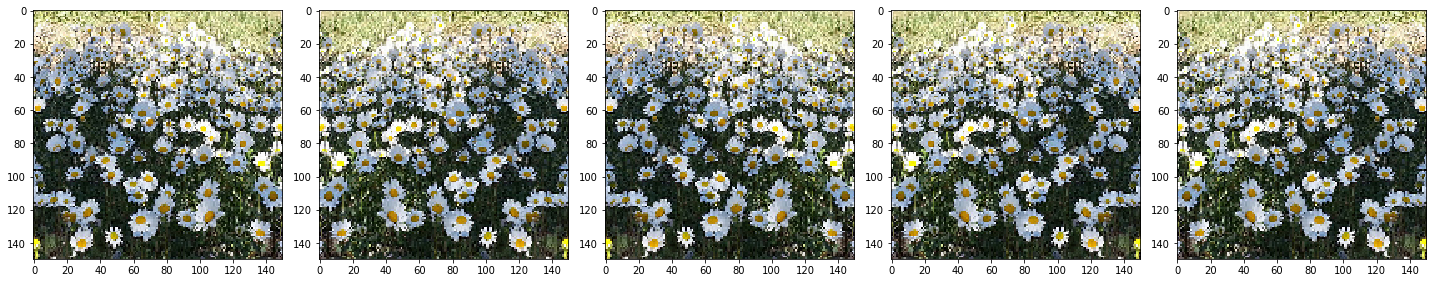

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TOO: Apply Random Rotation

以下のセルで、ImageDataGeneratorを使用して、イメージを255で再スケーリングし、ランダムな45度回転を適用する変換を作成します。 次に、 `.flow_from_directory`メソッドを使用して、トレーニングセットの画像に上記の変換を適用します。 バッチサイズ、トレーニングイメージのディレクトリへのパス、イメージのターゲットサイズを指定し、イメージをシャッフルするようにしてください。


In [13]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


トレーニングの例から1つのサンプル画像を取得し、5回繰り返して、同じ画像にランダムに5回拡張を適用して、拡張の実際を確認してみましょう。

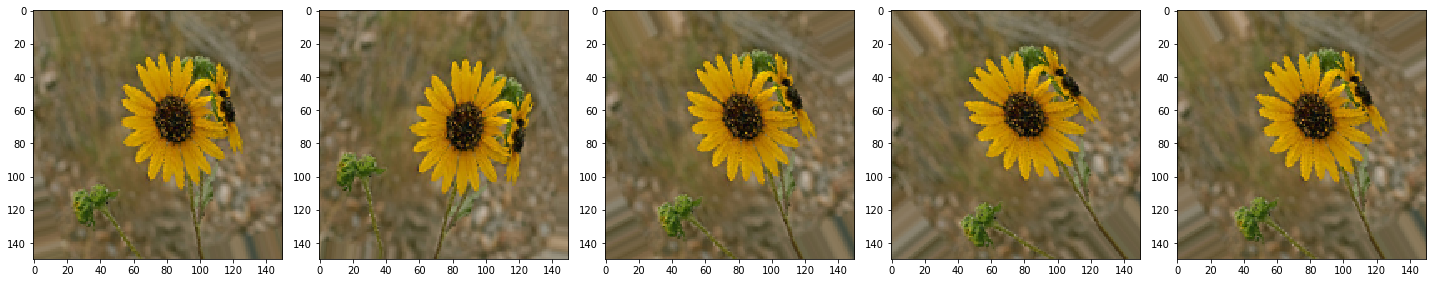

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Zoom

以下のセルで、ImageDataGeneratorを使用して、イメージを255で再スケーリングし、最大50％のランダムズームを適用する変換を作成します。 次に、 `.flow_from_directory`メソッドを使用して、トレーニングセットの画像に上記の変換を適用します。 バッチサイズ、トレーニングイメージのディレクトリへのパス、イメージのターゲットサイズを指定し、イメージをシャッフルするようにしてください。


In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


トレーニングの例から1つのサンプル画像を取得し、5回繰り返して、同じ画像にランダムに5回拡張を適用して、拡張の実際を確認してみましょう。

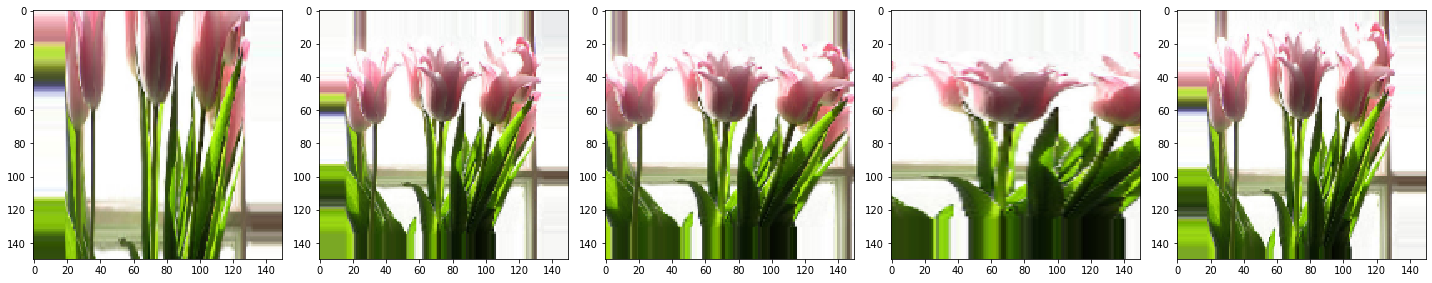

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Put It All Together

以下のセルで、ImageDataGeneratorを使用して、画像を255で再スケーリングして適用する変換を作成します。

- ランダムな45度回転
- 最大50％のランダムズーム
- ランダムな水平反転
- 幅シフト0.15
- 0.15の高さシフト

次に、 `.flow_from_directory`メソッドを使用して、トレーニングセットの画像に上記の変換を適用します。 バッチサイズ、トレーニングイメージのディレクトリへのパス、イメージのターゲットサイズ、イメージのシャッフル、およびクラスモードを「スパース」に設定するようにしてください。

In [17]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


これらの増強をデータセットにランダムに渡すと、単一の画像が5つの異なる時間のように見える様子を視覚化してみましょう。

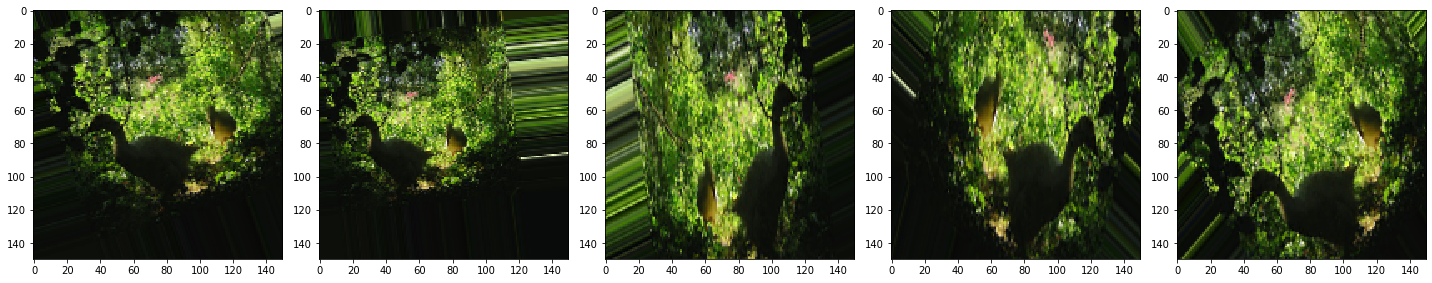

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Create a Data Generator for the Validation Set

一般的に、トレーニングの例にはデータ増強のみを適用します。 したがって、下のセルで、ImageDataGeneratorを使用して、画像を255だけ再スケーリングする変換を作成します。次に、 `.flow_from_directory`メソッドを使用して、検証セットの画像に上記の変換を適用します。 バッチサイズ、検証イメージのディレクトリへのパス、イメージのターゲットサイズを指定し、クラスモードを「スパース」に設定してください。 検証セットの画像をシャッフルする必要はないことに注意してください。


In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


# TODO: Create the CNN

下のセルで、3つの畳み込みブロックで構成される畳み込みニューラルネットワークを作成します。 各畳み込みブロックには、「Conv2D」レイヤーとそれに続く最大プールレイヤーが含まれます。 最初の畳み込みブロックには16個のフィルター、2番目の畳み込みブロックには32個のフィルター、3番目のブロックには64個のフィルターが必要です。 すべての畳み込みフィルターは3 x 3である必要があります。すべての最大プールレイヤーには、「（2、2）」の「pool_size」が必要です。

3つの畳み込みブロックの後に、平らな層があり、その後に512ユニットで完全に接続された層が続きます。 CNNは、**softmax**アクティベーション関数によって実行される5つのクラスに基づいてクラス確率を出力する必要があります。 他のすべてのレイヤーは、**relu**アクティベーション関数を使用する必要があります。 必要に応じて、20％の確率でドロップアウトレイヤーを追加する必要があります。


In [20]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# TODO: Compile the Model

以下のセルで、ADAMオプティマイザー、損失関数としてのスパースクロスエントロピー関数を使用してモデルをコンパイルします。 また、ネットワークをトレーニングする際に、各エポックでのトレーニングと検証の精度を確認したいので、メトリックス引数も渡すようにしてください。


In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# TODO: Train the Model

下のセルで、通常の**fit**関数の代わりに**fit_generator**関数を使用してモデルをトレーニングします。 モデルのトレーニングおよび検証データのバッチを生成するために**ImageDataGenerator**クラスを使用しているため、 `fit_generator`関数を使用する必要があります。 80エポックのモデルを訓練し、 `fit_generator`関数で適切なパラメーターを使用していることを確認してください。

In [23]:
#epochs = 80
epochs = 5

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/5
30/30 [==============================] - 47s 2s/step - loss: 1.1899 - accuracy: 0.4968 - val_loss: 1.1419 - val_accuracy: 0.5483
Epoch 2/5
30/30 [==============================] - 48s 2s/step - loss: 1.0758 - accuracy: 0.5704 - val_loss: 1.1207 - val_accuracy: 0.5578
Epoch 3/5
30/30 [==============================] - 46s 2s/step - loss: 1.0272 - accuracy: 0.5935 - val_loss: 0.9964 - val_accuracy: 0.6190
Epoch 4/5
30/30 [==============================] - 46s 2s/step - loss: 0.9703 - accuracy: 0.6174 - val_loss: 1.0047 - val_accuracy: 0.6231
Epoch 5/5
30/30 [==============================] - 46s 2s/step - loss: 0.9001 - accuracy: 0.6487 - val_loss: 0.9204 - val_accuracy: 0.6340


# TODO: Plot Training and Validation Graphs.

下のセルに、トレーニングと検証の精度/損失グラフをプロットします。

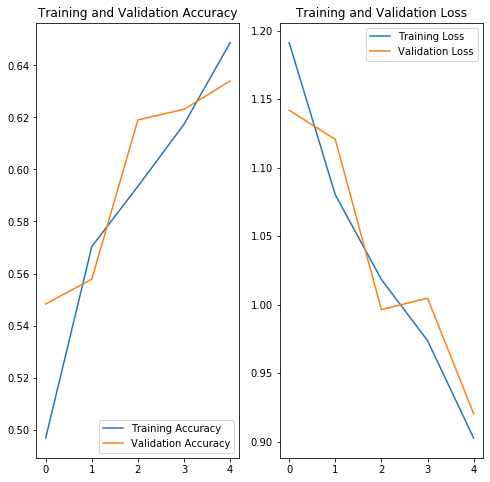

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()